##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>


In [ ]:
#@title
%%html
<iframe src="https://www.polskacyfrowa.gov.pl/media/48246/FE_POPC_poziom_pl-1_rgb.jpg" width="800"></iframe>


# Uczenie głębokie

Jacek Rumiński, Politechnika Gdańska, Wydział ETI, Katedra Inżynierii Biomedycznej

**Wykład 7:** Autokodery głębokie

**Przykład (2):** Autokodery z warstwami splotowymi


Istotę autokoderów poznaliśmy w czasie prezentacji i w przykładach z uczenia maszynowego. W tym notatniku skupimy się na głębokich wersjach autokoderów z zastosowaniem warstw z sieci splotowych.


In [ ]:
# Read packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, losses



print(tf.__version__)

2.9.2


170498071/170498071 [==============================] - 3s 0us/step
True original label : 6 frog


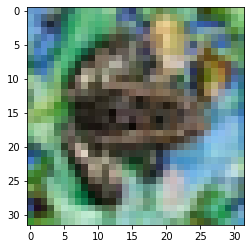

In [ ]:
# Load data and split to training and test datasets

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = [
'airplane','automobile','bird', 'cat', 'deer' ,
'dog', 'frog', 'horse', 'ship', 'truck']

# Data properties
image_width = 32;
image_height = 32;
image_components = 3


x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Show an example
example = 200
class_id = y_train[example].item()

plt.rcParams["axes.grid"] = False
plt.imshow(x_train[example])
print("True original label :", class_id, class_names[class_id])


Zaproponujmy teraz model autokodera, który będzie zmieniał reprezentację danych do nowej E wymiarowej przestrzeni ukrytej. Wprowadźmy zmienną latent_space_dim do określenia wymiaru E (będziemy mogli eksperymentować z wpływem doboru rozmiaru reprezentacji danych w przestrzeni ukrytej na wyniki autokodera).

Jeśli E < L (liczba cech zbioru oryginalnego) mówimy o niekompletnych autokoderach (ang. undercomplete autoencoders).

Jeśli E > L mówimy o nadkompletnych autokoderach (ang. overcomplete autoencoders), często związanych z danymi reprezentowanymi w warstwie ukrytej w sposób rzadki (dużo zer - wiele neuronów nieaktywnych) - ang. sparse autoencoders.

Zajmijmy się przypadkiem E<L. Zaadaptujmy model poznany wczesniej w czasie prezentacji z kursu na temat uczenia maszynowego. Poprzednio uzywaliśmy zbioru MNIST (28,18,1). Teraz uzywamy zbioru CIFAR, który charakteryzuje się większą liczbą komponentów koloru (32,32,3). Uwzględnijmy tę różnicę w modelu.



In [ ]:
class AE(tf.keras.models.Model):
  def __init__(self, data_shape, lat_dim, enc_act, dec_act):
    super(AE, self).__init__()
    self.latent_space_dim = lat_dim
    self.m_name = "Dense Shallow Autoencoder"

    self.encoder = tf.keras.Sequential([
      # Data shape (50000, 32, 32, 3), so make it flat for the Dense layer
      layers.Flatten(),
      layers.Dense(self.latent_space_dim, activation=enc_act),
    ])

    self.decoder = tf.keras.Sequential([
      # Data shape (50000, 32, 32, 3), so output 32*32
      layers.Dense(data_shape[1]*data_shape[2]*data_shape[3], activation=dec_act),
      layers.Reshape((data_shape[1],data_shape[2],data_shape[3]))
    ])

  # forward projection
  def call(self, x):
    z = self.encoder(x)
    x_e = self.decoder(z)
    return x_e

Zastosujmy model dla danych CIFAR definiując przykładowe wartości hiperparsametrów i przeprowadźmy trening.

In [ ]:
latent_space_dim = 8*8*3
encoder_activation = 'relu'
decoder_activation = 'sigmoid'
epochs = 20
print(x_train.shape)

ae = AE(x_train.shape, latent_space_dim, encoder_activation, decoder_activation)
ae.compile(optimizer='adam', loss=losses.MeanSquaredError())

ae.fit(x_train, x_train, epochs=epochs, shuffle=True,
       validation_data=(x_test, x_test))

in_shape = x_train[0].shape
in_shape_size = in_shape[0] * in_shape[1] * in_shape[2]
print("\n\n")
print(f"Input shape is {in_shape}, data length is {in_shape_size}")
print(f"Latent space data length is {ae.latent_space_dim}")

if in_shape_size > ae.latent_space_dim:
    print(f"The {ae.m_name} is an undercomplete autoencoder")
else:
    print(f"The {ae.m_name} is a overcomplete autoencoder")


(50000, 32, 32, 3)
Epoch 1/20
1563/1563 [==============================] - 8s 4ms/step - loss: 0.0255 - val_loss: 0.0177
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0152 - val_loss: 0.0133
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0123 - val_loss: 0.0124
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0123 - val_loss: 0.0124
Epoch 8/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 9/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 10/20
1563/1563 [==============================] - 5s 3ms

Zobcmzy ile parametrów mają poszczególne bloki autokodera.

In [ ]:
print("Total DAE model summary:")
ae.summary()


print("Encoder summary:")
ae.encoder.summary()

print("Decoder summary:")
ae.decoder.summary()

Total DAE model summary:
Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 192)               590016    
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         592896    
                                                                 
Total params: 1,182,912
Trainable params: 1,182,912
Non-trainable params: 0
_________________________________________________________________
Encoder summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 192)               590016    
                                                          

W celu ilustracji działania zastosujmy koder i dekoder dla zbioru testowego.

In [ ]:
img_encoded = ae.encoder(x_test).numpy()
img_decoded = ae.decoder(img_encoded).numpy()

print("Evaluate")
result = ae.evaluate(x_test, x_test)
print(ae.metrics_names)
print(result)

Evaluate
313/313 [==============================] - 1s 2ms/step - loss: 0.0121
['loss']
0.01210116595029831


Zilustrujmy następnie obraz oryginalny oraz zrekonstruowany przez autokoder.

Input representation dimension (shape): (32, 32, 3)
Latent space dimension (shape): (192,)
Label for the example: dog


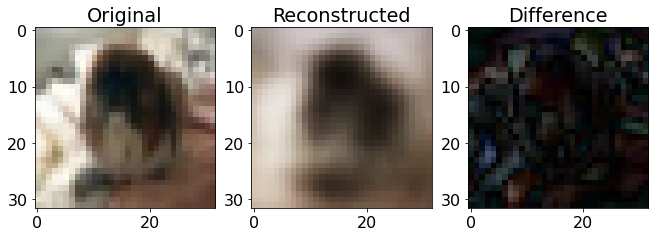

In [ ]:
example = 200

print("Input representation dimension (shape):", x_test[example].shape)
print("Latent space dimension (shape):", img_encoded[example].shape)

print("Label for the example:", class_names[int(y_test[example])])

matplotlib.rcParams.update({'font.size': 16})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,11))

ax1.set_title("Original")
ax1.imshow(x_test[example], cmap='gray')

ax2.set_title("Reconstructed")
ax2.imshow(img_decoded[example], cmap='gray')

ax3.set_title("Difference")
ax3.imshow(np.abs(img_decoded[example]-x_test[example]), cmap='gray')
plt.show()

Możemy zaobserwować efekt znacznego wygładzenia obrazu (wygładzenie to filtracja dolnoprzepustowa - zmniejszamy częstotliwości przestrzenne, czyli liczbę zmian wartości pikseli na jednostkę długości).

Tak prosty model wytrenowany dla niewielkiej liczbie epok niezbyt dobrze rokonstruuje dane wejściowe. Zachęcam do eksperymentowania z liczbą warstw Dense, z liczbą parametrów, itp.

Oczywiste staje się jednal pytanie, czy moglibyśmy zastosować wyuczony autokoder do odszumiania obrazów.

Wygenerujemy obraz z szumem i zastosujmy TEN SAM model, który trenowaliśmy wyżej.

 Max noise value is 0.42645982003216903


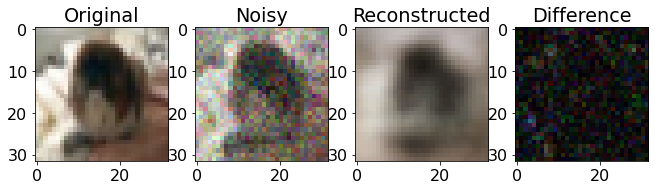

In [ ]:
noise_amp = 0.1
noise = noise_amp * np.random.normal(size=(32,32,3))
print(f" Max noise value is {np.max(noise)}")
true_image = x_test[example]
img_example = np.array(true_image + noise)
img_example = np.interp(img_example, (img_example.min(), img_example.max()), (0, 1))

img_example=img_example.reshape((1,32,32,3))


img_example_encoded = ae.encoder(img_example).numpy()
img_example_decoded = ae.decoder(img_example_encoded).numpy()

matplotlib.rcParams.update({'font.size': 16})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(11,11))

ax1.set_title("Original")
ax1.imshow(true_image, cmap='gray')

ax2.set_title("Noisy")
ax2.imshow(img_example[0], cmap='gray')

ax3.set_title("Reconstructed")
ax3.imshow(img_example_decoded[0], cmap='gray')

ax4.set_title("Difference")
ax4.imshow(np.abs(img_example_decoded[0]-img_example[0]), cmap='gray')
plt.show()

Udało nam sie zredukować szum wysokiej częśtotliwości, ale nasz zrekonstruowany obraz jest ciągle bardzo rozmyty.

# GŁĘBOKIE AUTOKODERY

Zdefiniujmy teraz model bazujący wyłącznie na warstwach poznanych przy omawianiu modeli splotowych.

W tej wersji modelu przyjmiemy jako parametr rozmiar głębokości (liczbę kanałów) przestrzeni ukrytej. Redukcję danych w koderze zrealizujemy poprzez operację MaxPooling zachowując przy tym rozmiar obrazów dla operacji splotu (odpowiednia wartość zmienne padding='same').


In [ ]:
class DAE(tf.keras.models.Model):
  def __init__(self, data_shape, lat_dim, enc_act, dec_act, padding='same'):
    super(DAE, self).__init__()
    self.channel_dim = lat_dim
    self.latent_space_dim = lat_dim * 8 * 8  # assuming 2xMaxPool in the encoder
    self.m_name = "Simple Convolutional Autoencoder"

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(32, 3, activation=enc_act, padding=padding),
      #layers.LayerNormalization(),
      layers.MaxPool2D(2),
      layers.Conv2D(64, 3, activation=enc_act, padding=padding),
      #layers.LayerNormalization(),
      layers.MaxPool2D(2),
      layers.Conv2D(self.channel_dim, 3, activation=enc_act, padding=padding),
      layers.LayerNormalization(),
    ])

    # We used MaxPool two times, so we need to upscale two times in the decoder
    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D((2,2)),
      layers.Conv2D(64, 3,activation=dec_act, padding=padding),
      #layers.LayerNormalization(),
      layers.UpSampling2D((2,2)),
      layers.Conv2D(32, 3,activation=dec_act, padding=padding),
      #layers.LayerNormalization(),
      layers.Conv2D(3, 1),  # Generate 3 channels
      layers.Activation("sigmoid"),  # Scale output to get values in range (0,1)
    ])

  # forward projection
  def call(self, x):
    z = self.encoder(x)
    x_e = self.decoder(z)
    return x_e

Kolejne operacje zróbmy takie same jak dla pierwszego, prostego modelu autokodera płytkiego.

In [ ]:
latent_space_depth_dim = 3  # if spatial shape is (8,8) then latent_space_dim is 8*8*latent_space_depth_dim
encoder_activation = 'relu'
decoder_activation = 'sigmoid'
epochs = 20
print(x_train.shape)

ae = DAE(x_train.shape, latent_space_depth_dim, encoder_activation, decoder_activation)
ae.compile(optimizer='adam', loss=losses.MeanSquaredError())

ae.fit(x_train, x_train, epochs=epochs, shuffle=True,
       validation_data=(x_test, x_test))

in_shape = x_train[0].shape
in_shape_size = in_shape[0] * in_shape[1] * in_shape[2]
print("\n\n")
print(f"Input shape is {in_shape}, data length is {in_shape_size}")
print(f"Latent space data length is {ae.latent_space_dim}")

if in_shape_size > ae.latent_space_dim:
    print(f"The {ae.m_name} is an undercomplete autoencoder")
else:
    print(f"The {ae.m_name} is a sparse autoencoder")

(50000, 32, 32, 3)
Epoch 1/20
1563/1563 [==============================] - 16s 6ms/step - loss: 0.0153 - val_loss: 0.0133
Epoch 2/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 5/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 6/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 7/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 8/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 9/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 10/20
1563/1563 [==============================] -

In [ ]:
print("Total DAE model summary:")
ae.summary()


print("Encoder summary:")
ae.encoder.summary()

print("Decoder summary:")
ae.decoder.summary()

Total DAE model summary:
Model: "dae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 8, 8, 3)           21129     
                                                                 
 sequential_3 (Sequential)   (None, 32, 32, 3)         20355     
                                                                 
Total params: 41,484
Trainable params: 41,484
Non-trainable params: 0
_________________________________________________________________
Encoder summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                           

In [ ]:
img_encoded = ae.encoder(x_test).numpy()
img_decoded = ae.decoder(img_encoded).numpy()

print("Evaluate")
result = ae.evaluate(x_test, x_test)
print(ae.metrics_names)
print(result)


Evaluate
313/313 [==============================] - 1s 3ms/step - loss: 0.0121
['loss']
0.012102036736905575


Input representation dimension (shape): (32, 32, 3)
Latent space dimension (shape): (8, 8, 3)
Label for the example: dog


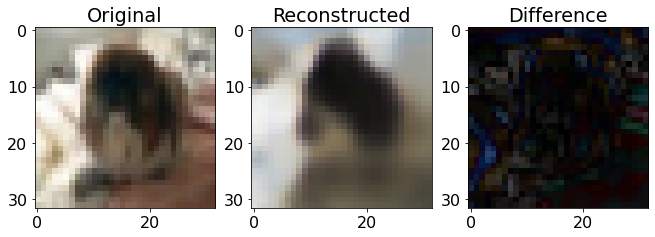

In [ ]:
example = 200

print("Input representation dimension (shape):", x_test[example].shape)
print("Latent space dimension (shape):", img_encoded[example].shape)

print("Label for the example:", class_names[int(y_test[example])])

matplotlib.rcParams.update({'font.size': 16})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,11))

ax1.set_title("Original")
ax1.imshow(x_test[example], cmap='gray')

ax2.set_title("Reconstructed")
ax2.imshow(img_decoded[example], cmap='gray')

ax3.set_title("Difference")
ax3.imshow(np.abs(img_decoded[example]-x_test[example]), cmap='gray')
plt.show()

Jak widać efekt rekonstrukcyjny jest znacznie lepszy niż dla prostego, płytkiego autokodera przy podobnej liczbie epok.

 Max noise value is 0.39229029392784454


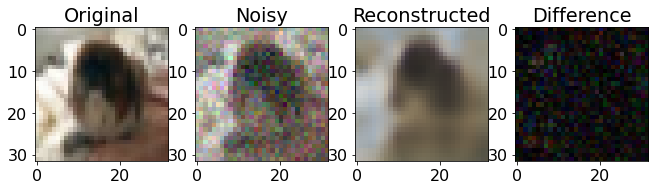

In [ ]:
noise_amp = 0.1
noise = noise_amp * np.random.normal(size=(32,32,3))
print(f" Max noise value is {np.max(noise)}")
true_image = x_test[example]
img_example = np.array(true_image + noise)
img_example = np.interp(img_example, (img_example.min(), img_example.max()), (0, 1))

img_example=img_example.reshape((1,32,32,3))


img_example_encoded = ae.encoder(img_example).numpy()
img_example_decoded = ae.decoder(img_example_encoded).numpy()

matplotlib.rcParams.update({'font.size': 16})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(11,11))

ax1.set_title("Original")
ax1.imshow(true_image, cmap='gray')

ax2.set_title("Noisy")
ax2.imshow(img_example[0], cmap='gray')

ax3.set_title("Reconstructed")
ax3.imshow(img_example_decoded[0], cmap='gray')

ax4.set_title("Difference")
ax4.imshow(np.abs(img_example_decoded[0]-img_example[0]), cmap='gray')
plt.show()

Zasotosowany model dla danych zaszumionych zredukował szum, ale zrekonstruowany obraz nie jest w pełni zadawalający.



Zachęcam do eksperymentowania:
1. Zmniejsz współczynnik kompresji, czyli zwiększ wymiar latent space
2. Wprowdzić zmiany do procedury treningu: więcej epok, itp.
3. Wprowadzić zmiany do wyżej przedstawionego modelu autokodera - dodać inne warstwy i elementy topologii poznane z wcześniejszych zajęć (np. elementy bloku incepcji lub bloku rezydualnego).
4. Przetrenować model na danych zaszumionych (X) względem danych oryginalnych (Y) i sprawdzić jak model poradzi sobie z zaszumionymi danymi testowymi.
5. Zastosuj warstwę Conv2DTranspose zamiast UpSampling2D i Conv2D
5. itd.

Na koniec zaproponujmy model wykorzystujący zarówno warstwy splotowe jak i warstwy gęste (Dense).


In [ ]:
class DMAE(tf.keras.models.Model):
  def __init__(self, data_shape, lat_dim, enc_act, dec_act, padding='same'):
    super(DMAE, self).__init__()
    self.spatial_dim = lat_dim
    self.latent_space_dim = lat_dim * 3
    self.rows_columns = int(np.sqrt(lat_dim))
    self.m_name = "Mixed Convolutional Autoencoder"

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(32, 3, activation=enc_act, padding=padding),
      layers.MaxPool2D(2),
      layers.Conv2D(64, 3, activation=enc_act, padding=padding),
      layers.MaxPool2D(2),
      layers.Conv2D(128, 3, activation=enc_act, padding=padding),
      layers.LayerNormalization(),
      # Spatial shape is (8,8) - we used MaxPool two times
      layers.Flatten(),
      layers.Dense(self.latent_space_dim, activation=enc_act),
    ])

    # We used MaxPool two times, so we need to upscale two times in the decoder
    self.decoder = tf.keras.Sequential([
      layers.Dense(self.latent_space_dim, activation=dec_act),
      layers.Reshape((self.rows_columns, self.rows_columns, data_shape[3])),
      # BE CAREFUL - tune upscaling to latent space dim
      # Restore the resolution: upscale with interpolation and normal convolution
      layers.UpSampling2D((2, 2), interpolation="nearest"),
      layers.Conv2D(64, 3, activation=dec_act, padding=padding),
      layers.UpSampling2D((2,2), interpolation="nearest"),
      layers.Conv2D(32, 3, activation=dec_act, padding=padding),
      # OR - pptionally, Use Conv2DTranspose with stride=2 to upscale and pseudo-deconvolution
      # To do so, please replase 2 pairs of UpSampling2D and Conv2D layers with:
      # layers.Conv2DTranspose(64, 3, strides=(2, 2), activation=dec_act, padding=padding),
      # layers.Conv2DTranspose(32, 3, strides=(2, 2), activation=dec_act, padding=padding),

      layers.Conv2D(3, 1),  # Generate 3 channels
      layers.Activation("sigmoid"),  # Scale output to get values in range (0,1)
    ])

  # forward projection
  def call(self, x):
    z = self.encoder(x)
    x_e = self.decoder(z)
    return x_e

Przprowadźmy trening modelu.

In [ ]:
latent_space_depth_dim = 8*8
encoder_activation = 'relu'
decoder_activation = 'sigmoid'
epochs = 20
print(x_train.shape)

ae = DMAE(x_train.shape, latent_space_depth_dim, encoder_activation, decoder_activation)
ae.compile(optimizer='adam', loss=losses.MeanSquaredError())

ae.fit(x_train, x_train, epochs=epochs, shuffle=True,
       validation_data=(x_test, x_test))


in_shape = x_train[0].shape
in_shape_size = in_shape[0] * in_shape[1] * in_shape[2]
print("\n\n")
print(f"Input shape is {in_shape}, data length is {in_shape_size}")
print(f"Latent space data length is {ae.latent_space_dim}")

if in_shape_size > ae.latent_space_dim:
    print(f"The {ae.m_name} is an undercomplete autoencoder")
else:
    print(f"The {ae.m_name} is a sparse autoencoder")

(50000, 32, 32, 3)
Epoch 1/20
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0178 - val_loss: 0.0133
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0119 - val_loss: 0.0089
Epoch 3/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 5/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 8/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 9/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 10/20
1563/1563 [==============================]

In [ ]:
print("Total DAE model summary:")
ae.summary()


print("Encoder summary:")
ae.encoder.summary()

print("Decoder summary:")
ae.decoder.summary()

Total DAE model summary:
Model: "dmae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 192)               1666560   
                                                                 
 sequential_5 (Sequential)   (None, 32, 32, 3)         57411     
                                                                 
Total params: 1,723,971
Trainable params: 1,723,971
Non-trainable params: 0
_________________________________________________________________
Encoder summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

Porównajmy wartośc funkcjo kosztu dla zbioru testowego bieżącego modelu, z modelem poprzednim.

In [ ]:
img_encoded = ae.encoder(x_test).numpy()
img_decoded = ae.decoder(img_encoded).numpy()
print("Evaluate")
result = ae.evaluate(x_test, x_test)
print(ae.metrics_names)
print(result)

Evaluate
313/313 [==============================] - 1s 3ms/step - loss: 0.0052
['loss']
0.005219983868300915


Input representation dimension (shape): (32, 32, 3)
Latent space dimension (shape): (192,)
Label for the example: dog


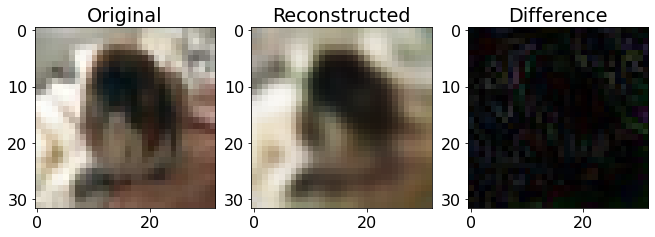

In [ ]:
example = 200

print("Input representation dimension (shape):", x_test[example].shape)
print("Latent space dimension (shape):", img_encoded[example].shape)

print("Label for the example:", class_names[int(y_test[example])])

matplotlib.rcParams.update({'font.size': 16})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,11))

ax1.set_title("Original")
ax1.imshow(x_test[example], cmap='gray')

ax2.set_title("Reconstructed")
ax2.imshow(img_decoded[example], cmap='gray')

ax3.set_title("Difference")
ax3.imshow(np.abs(img_decoded[example]-x_test[example]), cmap='gray')
plt.show()

 Max noise value is 0.35368445131364584


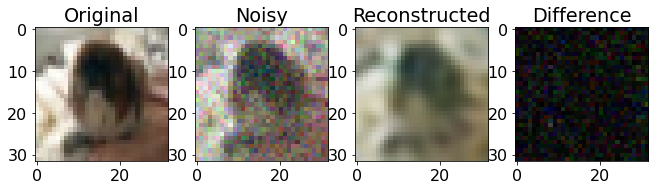

In [ ]:
noise_amp = 0.1
noise = noise_amp * np.random.normal(size=(32,32,3))
print(f" Max noise value is {np.max(noise)}")
true_image = x_test[example]
img_example = np.array(true_image + noise)
img_example = np.interp(img_example, (img_example.min(), img_example.max()), (0, 1))

img_example=img_example.reshape((1,32,32,3))


img_example_encoded = ae.encoder(img_example).numpy()
img_example_decoded = ae.decoder(img_example_encoded).numpy()

matplotlib.rcParams.update({'font.size': 16})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(11,11))

ax1.set_title("Original")
ax1.imshow(true_image, cmap='gray')

ax2.set_title("Noisy")
ax2.imshow(img_example[0], cmap='gray')

ax3.set_title("Reconstructed")
ax3.imshow(img_example_decoded[0], cmap='gray')

ax4.set_title("Difference")
ax4.imshow(np.abs(img_example_decoded[0]-img_example[0]), cmap='gray')
plt.show()

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>